Как получить данные (еще можно делать это же с помощью API: https://scihub.copernicus.eu/userguide/5APIsAndBatchScripting)

1. Зайти на https://scihub.copernicus.eu/dhus/#/home
2. Найти область, откуда нужны данные (нужно зарегистрироваться), с помощью advanced search выбрать дату.
3. Скачать интересующие файлы. Изображения лежат в подпапке 'measurements'
4. Порезать их на части удобного размера. Файлы очень большие, и многие редакторы не смогут их открыть. Я использовал утилиту imagemagick:
```
convert -crop 3200x3200 <input name> <output_template>
```

Ниже приведены примеры обработки кусочка изображения Московской области.

In [1]:
%matplotlib inline
import itertools
import os.path

import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage.io
import skimage.feature
from sklearn.cluster import k_means

In [2]:
DATA_PATH = os.path.expanduser('~/Data')
img = skimage.io.imread(os.path.join(DATA_PATH, 'S1-Moscow-02-26', 'measurement', 'vv_part-10.png'))[:1000, :1000]

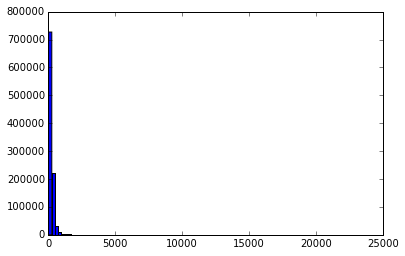

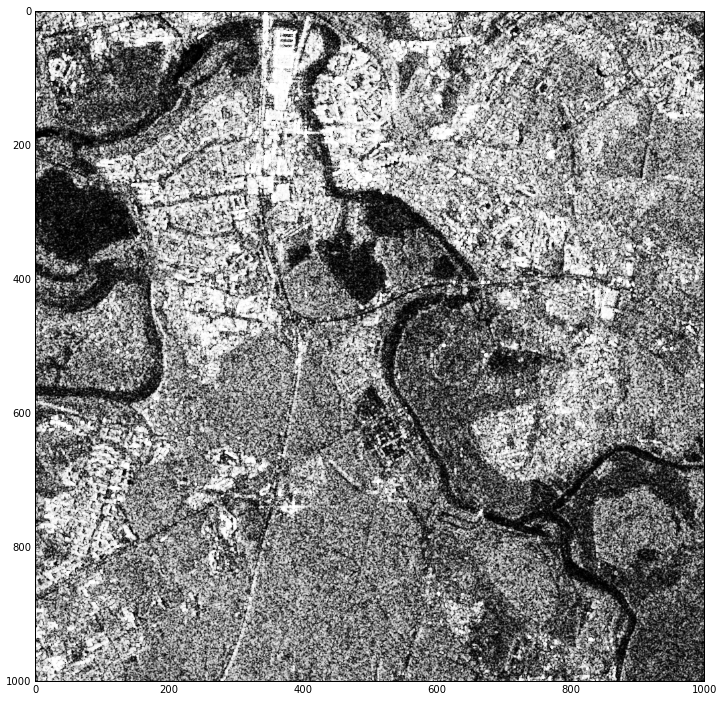

In [3]:
plt.hist(img.flatten(), bins=100)

img_eq = skimage.exposure.equalize_hist(img)

plt.figure(figsize=(12, 12))
plt.imshow(img_eq, cmap='gray')

In [4]:
def extract_patches(image, patch_shape, step):
    rows_domain = range(0, image.shape[0] - patch_shape[0] + 1, step[0])
    cols_domain = range(0, image.shape[1] - patch_shape[1] + 1, step[1])
    for row_start, col_start in itertools.product(rows_domain, cols_domain):
        patch = image[row_start : row_start + patch_shape[0],
                      col_start : col_start + patch_shape[1]]
        yield patch

PATCH_SHAPE = (8, 8)
PATCH_STEP = (4, 4)
patches = list(extract_patches(img_eq, PATCH_SHAPE, PATCH_STEP))
print(len(patches))

62001


In [5]:
def patch_features(patch):
    features = []
    
    # moments
    features += [
        patch.mean(),
        patch.std(),
        scipy.stats.skew(patch.flatten()),
    ]
    
    # histogram
    bins, _ = np.histogram(patch.flatten(), bins=25, range=(0, 1.0))
    features += list(bins)
    
    # edges strength
    edges = skimage.feature.canny(patch)
    features += [
        edges.sum(),
        edges.max(),
    ]
    
    return np.array(features)

In [6]:
data = np.vstack([patch_features(p) for p in patches])

In [7]:
_, labels2, _ = k_means(data, n_clusters=2)
_, labels4, _ = k_means(data, n_clusters=4)
_, labels6, _ = k_means(data, n_clusters=6)

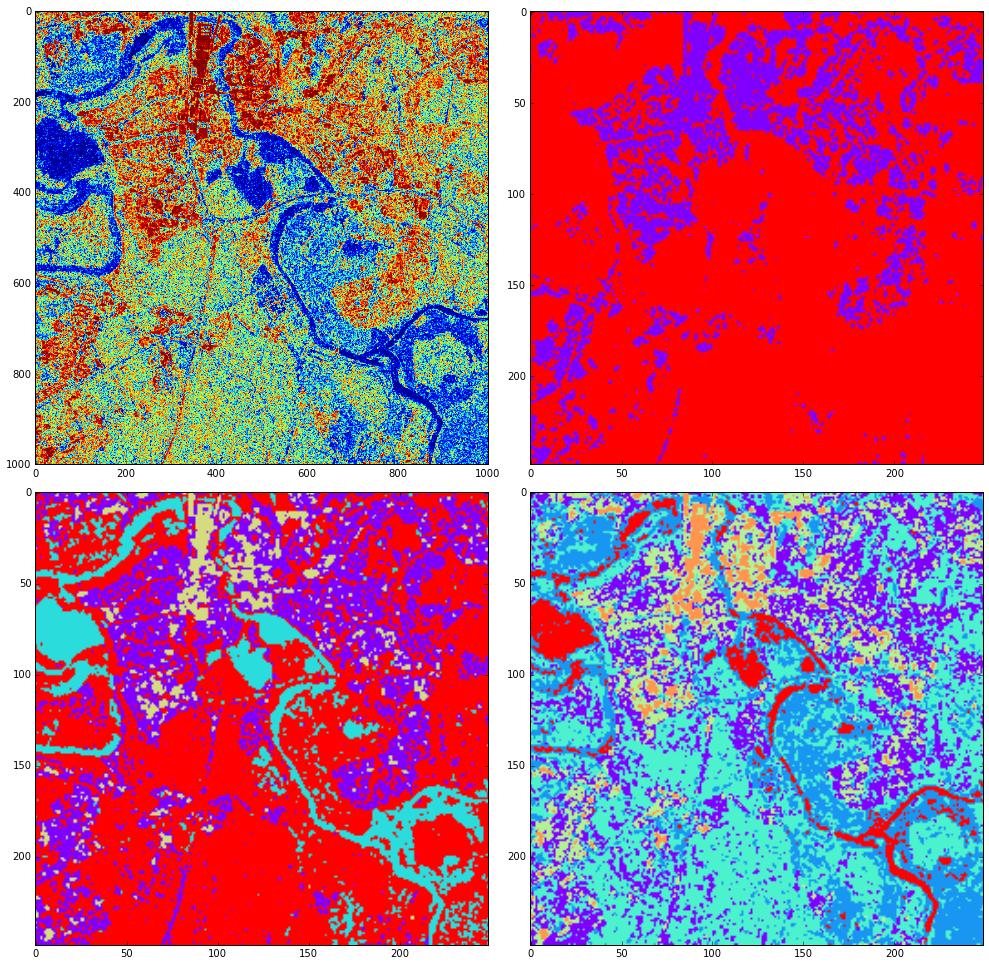

In [8]:
MAP_SIZE = int(len(patches) ** 0.5)
MAP_SHAPE = (MAP_SIZE, MAP_SIZE)

def make_map(labels, shape):
    clusters_map = np.zeros(shape)
    for r, c in itertools.product(*map(range, shape)):
        label_index = r * shape[0] + c
        clusters_map[r, c] = labels[label_index]
    return clusters_map
    
plt.figure(figsize=(14, 20))
plt.subplot(3, 2, 1)
plt.imshow(img_eq)
plt.subplot(3, 2, 2)
plt.imshow(make_map(labels2, MAP_SHAPE), cmap='rainbow')
plt.subplot(3, 2, 3)
plt.imshow(make_map(labels4, MAP_SHAPE), cmap='rainbow')
plt.subplot(3, 2, 4)
plt.imshow(make_map(labels6, MAP_SHAPE), cmap='rainbow')
plt.tight_layout()